# Przetwarzanie języka naturalnego w Pythonie

Ten notatnik ma na celu przedstawienie podstawowych kroków, które należy wykonać podczas analizy i klasyfikacji tekstów. W trakcie zadania będziemy tworzyć szereg funkcji pomocniczych, które na koniec wykorzystamy do klasyfikacji krótkich dokumentów tekstowych.

Po wykonaniu tego zadania powinieneś:
+ wiedzieć na czym polega i jak wykonać tokenizację,
+ potrafić wykonać podstawowy stemming,
+ potrafić analizować najpopularniejsze i narzadsze tokeny w zbiorze dokumentów,
+ zdefiniować i usunąć stopwords,
+ wiedzieć jak zamienić zbiór dokumentów na reprezentację bag-of-words,
+ uruchomić wybrany klasyfikator na przetworzonym zbiorze danych.

## Przygotowanie

Na początek trochę bibliotek i przydatnych wyrażeń regularnych:

In [1]:
import re
import pandas as pd
import nltk

nltk.download('punkt')

RE_SPACES = re.compile("\s+")
RE_HASHTAG = re.compile("[@#][_a-z0-9]+")
RE_EMOTICONS = re.compile("(:-\))|(:p)|(:d+)|(:-\()|(:/)|(;-\))|(<3)|(=\))|(\)-:)|(:'\()|(8\))")
RE_HTTP = re.compile("http(s)://[/\.a-z0-9]+")

[nltk_data] Downloading package punkt to /home/zerkles/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Biblioteka [re](https://docs.python.org/2/library/re.html) pozwala definiować wyrażenia regularne, [pandas](http://pandas.pydata.org/) już znasz z ostatnich zajęć, a [nltk](http://www.nltk.org/) to podstawowa biblioteka do przetwarzania języka naturalnego w pythonie. `nltk` to spory zestaw modułów, który domyślnie nie jest instalowany w całości. Aby doinstalować wybrane moduły możesz w interaktywnej konsoli pythona wpisać:

`import nltk
nltk.download()`

Następnie w odpowiednich zakładkach wybrać interesujące moduły. W ramach tego ćwiczenia będziemy wykorzystywać moduł **`punkt`** z zakładki Modules, ale proszę zwrócić uwagę na interesujące korpusy i leksykony, takie jak np. `opinion_lexicon` czy `sentiwordnet`.

Przyda nam się też zbiór danych do testowania kodu.

**Zad. 1: Wczytaj zbiór danych `tweets_train.tsv` do zmiennej `tweets`. Pomiń nagłówek i pozostaw tylko ostatnią kolumnę. Wyświetl pierwsze 6 wierszy, żeby upewnić się, że każdy przykład składa się tylko z tekstu.**

In [2]:
tweets = pd.read_csv("tweets_train.tsv", sep='\t', usecols=[2], header=None)
print(tweets.head(6))

                                                   2
0  dear @Microsoft the newOoffice for Mac is grea...
1  @Microsoft how about you make a system that do...
2                                      Not Available
3                                      Not Available
4  If I make a game as a #windows10 Universal App...
5  Microsoft, I may not prefer your gaming branch...


## Tokenizacja i stemming

Żeby uporządkować trochę kod i kolejne kroki, wprowadźmy klasę Tokenizer i BeforeTokenizationNormalizer. Pierwsza będzie służyć jako klasa bazowa dla tworzonych przez tokenizatorów a druga zamieni encje html na poprawne znaki tekstowe.

In [3]:
class Tokenizer():
    @staticmethod
    def tokenize(text):
        pass


class BeforeTokenizationNormalizer():
    @staticmethod
    def normalize(text):
        text = text.strip().lower()
        text = text.replace('&nbsp;', ' ')
        text = text.replace('&lt;', '<')
        text = text.replace('&gt;', '>')
        text = text.replace('&amp;', '&')
        text = text.replace('&pound;', u'£')
        text = text.replace('&euro;', u'€')
        text = text.replace('&copy;', u'©')
        text = text.replace('&reg;', u'®')
        return text

Aby sprawdzić czy wszystko działa - odkomentuj poniższy kod:

In [4]:
for i in tweets.index:
    print(tweets[2][i])
    tweet = BeforeTokenizationNormalizer.normalize(tweets[2][i])
    # print(tweet)

dear @Microsoft the newOoffice for Mac is great and all, but no Lync update C'mon.
@Microsoft how about you make a system that doesn't eat my friggin discs. This is the 2nd time this has happened and I am so sick of it!
Not Available
Not Available
If I make a game as a #windows10 Universal App. Will #xboxone owners be able to download and play it in November @majornelson @Microsoft
Microsoft, I may not prefer your gaming branch of business. But, you do make a damn fine operating system. #Windows10 @Microsoft
@MikeWolf1980 @Microsoft I will be downgrading and let #Windows10 be out for almost the 1st yr b4 trying it again. #Windows10fail
@Microsoft 2nd computer with same error!!! #Windows10fail Guess we will shelve this until SP1! http://t.co/QCcHlKuy8Q
Just ordered my 1st ever tablet; @Microsoft Surface Pro 3, i7/8GB 512GB SSD. Hopefully it works out for dev to replace my laptop =)
After attempting a reinstall, it still bricks, says, "Windows cannot finish installing," or somesuch. @Mic

W kolejnych krokach będziesz implementował coraz bardziej wyrafinowane tokenizatory. Zacznijmy od czegoś w miarę intuicyjnego.

**Zad. 2: Napisz tokenizator, który dzieli słowa według spacji. Tokenizator powinien przyjmować tekst (pojedynczego stringa) i zamieniać go na listę słów. Przetestuj kod za pomocą zakomentowanej pętli.**

In [5]:
class SimpleTokenizer(Tokenizer):
    @staticmethod
    def tokenize(text):
        # Można w tym celu wykorzystać wyrażenie RE_SPACES. Jakie wady ma takie podejście Jak reaguje na znaki
        # interpunkcyjne Jeśli usuniesz interpunkcje, co się dzieje ze skrótowcami Jak obsłużyć słowa can't, o'clock,
        # we'd itp.

        words = RE_SPACES.split(text)
        # words = [re.sub("\W+", "", x) for x in words]

        return words


In [6]:
for i in tweets.index:
    tweet = BeforeTokenizationNormalizer.normalize(tweets[2][i])
    words_simple = SimpleTokenizer.tokenize(tweet)
    # print(words_simple)

**Zad. 3: Napisz tokenizator korzystający z funkcji word_tokenize() z biblioteki NLTK.**

In [7]:
class NltkTokenizer(Tokenizer):
    @staticmethod
    def tokenize(text):
        # Napisz tokenizator korzystający z funkcji word_tokenize() z biblioteki NLTK.
        # Czy w przypadku tweetów wszystkie słowa zostały poprawnie rozdzielone
        # wzór: At 8 o’clock I didn’t feel good. => |At|8|o’clock|I|did|n’t|feel|good|.|
        text = nltk.word_tokenize(text)
        return text

In [8]:
for i in tweets.index:
    tweet = BeforeTokenizationNormalizer.normalize(tweets[2][i])
    words_nltk = NltkTokenizer.tokenize(tweet)
    # print(words_nltk)

**Zad. 4: Napisz tokenizator, który oprócz standardowych słów obsłuży emitikony i hashtagi. Następnie wykonaj stemming (porter = nltk.PorterStemmer() porter.stem()).**

In [9]:
class TweetTokenizer(Tokenizer):
    @staticmethod
    def tokenize(text):
        tokens = SimpleTokenizer.tokenize(text)
        # print("---")
        # print(tokens)
        i = 0
        while i < len(tokens):
            token = tokens[i]

            # sprawdź czy w ramach tokena występuje emotikona, hashtag lub link
            match = re.search("|".join([RE_HASHTAG.pattern, RE_EMOTICONS.pattern, RE_HTTP.pattern]), token)
            if match is not None and match.group() != token:

                # wydziel emotikonę lub hashtag jako token a resztę tekstu rozpatrz ponownie

                # match_reg = "".join(['\\' + x for x in list(match.group())])[1:]
                # print(match_reg)
                # new_tokens = re.split(f"({match_reg})", match.string)
                # while '' in new_tokens: new_tokens.remove('')

                a, b = match.span()
                new_tokens = [token[:a], token[a:b], token[b:]]
                while '' in new_tokens: new_tokens.remove('')

                # print(match.string, match.group(), new_tokens)

                del tokens[i]
                tokens[i:i] = new_tokens

            else:
                del tokens[i]
                tokens[i:i] = NltkTokenizer.tokenize(token)
            i += 1

        # stwórz stemmer i w pętli stemmuj wszystkie tokeny
        porter = nltk.PorterStemmer()
        for i in range(len(tokens)):
            stem = porter.stem(tokens[i])
            tokens[i] = stem

        return tokens

In [10]:
for i in tweets.index:
    tweet = BeforeTokenizationNormalizer.normalize(tweets[2][i])
    words_tweet = TweetTokenizer.tokenize(tweet)
    # print(tweet)
    # print(words_tweet)

W wielu zastosowaniach dobrze działa lematyzacja, która również jest dostępna w `nltk`. W tym ćwiczeniu pozostaniemy jednak przy stemmingu.

## Stopwords

W tej części przeanalizujemy częstość występowania różnych słów w korpusie. Interesują nas słowa występujące najczęściej i najrzadziej. Ich analiza pozwoli określić jakie słowa powinny zostać pominięte podczas analizy a jakie powinny zostać połączone w grupy znaczeniowe.

W tym celu przyda nam się jakaś struktura danych do zliczania słów oraz funkcja do rysowania histogramów.

In [11]:
# % matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter

sns.set(style="whitegrid")
sns.set_color_codes("muted")


def show_histogram(word_counts, title=None):
    plot_df = pd.DataFrame.from_dict(word_counts).rename(columns={0: 'Token', 1: 'Count'})

    f, ax = plt.subplots(figsize=(12, 15))
    p = sns.barplot(x="Count", y="Token", data=plot_df, color="b")
    p.set(xlabel="Count", ylabel="", title=title)

Zacznijmy od zliczenia unikatowych słów. Pomoże nam w tym klasa [Counter](https://docs.python.org/2/library/collections.html#collections.Counter). Poniższy kod wypełnia kolekcję słowami po tokenizacji i stemmingu.

In [12]:
words = Counter()

for i in tweets.index:
    tweet = BeforeTokenizationNormalizer.normalize(tweets[2][i])
    words.update(TweetTokenizer.tokenize(tweet))

**Zad. 5: Wypisz, zwizualizuj i przeanalizuj 50 najczęściej występujących słów. Czy wszystkie wyświetlone tokeny będą przydatne w dalszej analizie Czy wszystkie tokeny to słowa**

[('.', 399), ('the', 395), (':', 347), ('amazon', 304), ('@', 283), (',', 278), ('to', 267), ('http', 239), ('prime', 202), ('i', 200), ('!', 200), ('on', 193), ('a', 167), ('it', 167), ('for', 147), ('#', 147), ('is', 137), ('and', 137), ('day', 137), ('in', 129), ('you', 113), ('of', 104), ("'s", 103), ('', 101), ('may', 101), ('friday', 99), ('ac/dc', 97), ('...', 95), ('merkel', 95), ('with', 93), ('my', 91), ('not', 90), ('be', 88), ('have', 88), ('angela', 88), ('microsoft', 85), ('at', 71), ('black', 70), ('tomorrow', 68), ('just', 66), ("n't", 65), ('avail', 60), ('that', 59), ('thi', 57), ('but', 48), ('go', 48), (')', 46), ('will', 44), ('wa', 43), ('see', 43)]


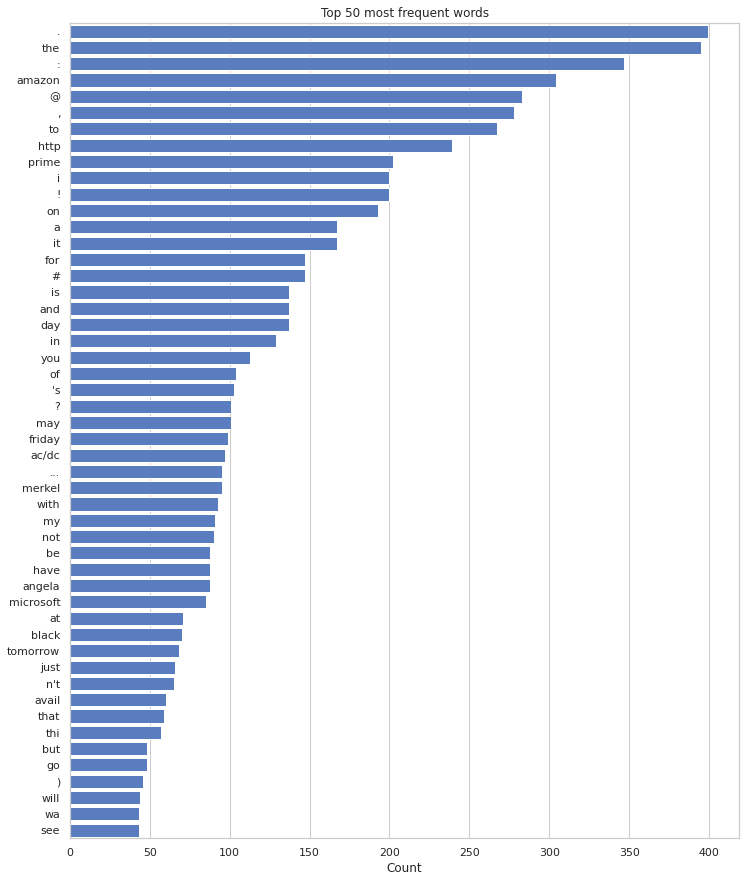

In [13]:
top_words = words.most_common(50)
print(top_words)
show_histogram(top_words, title="Top 50 most frequent words")


Widać, że nie wszystkie tokeny to słowa. Ponieważ budujemy słownik słów, które będą wykorzystywane do klasyfikacji tekstów, usuńmy podstawowe tokeny, które nie niosą żadnej informacji.

**Zad. 6: Usuń znaki interpunkcyjne z kolekcji words i powtórz analizę. Czy w przypadku badania opinii trzeba wyrzucić wszystkie znaki interpunkcyjne**

@
,

c'mon
.
n't
!
#
:
//t.co/qcchlkuy8q
;
i7/8gb
=
)
``
''
$
//t.co/7vtvazhwmv
&
's
-
8/19
//t.co/3dk6tozea8
//t.co/l2wozcwgrb
//t.co/lqvthe6chb
//t.co/loo3yd5rw
back-to-school
--
//t.co/xj21umvo0p
've
...
@microsoft
'm
win-7
//t.co/pxg1ypddcm
1-800-936-5700
(
>
//t.co/qop26oct4f
w/
'd
..
1/2
're
//t.co/p0bmrebbhc
//t.co/1xhmpdsvzq
@window
//t.co/0ai2qibbcr
//t.co/7nrwebqjen
//t.co/vzwgiolxco
tomorrow-
//t.co/y5wfguygfd
//t.co/rlksqtmneh
//t.co/lux5vvbrmj
//t.co/fdpz5jcqi6
time.m
//t.co/dtvc3mteo3
//t.co/trkifgmfto
handset/smartphon
//t.co/subgxxmqlz
#bi
@adob
730/735
release.plz
//t.co/mzkb5jtuxt
//t.co/mowneaobqk
//t.co/fkl9wdfkuz
//t.co/froubxxozu
#inbound15
//t.co/wwoujsslkt
//t.co/emvqoers6j
3.7
//t.co/iutbnxonfw
=at
//t.co/katcgjer4w
//t.co/9tj4nhkoyo
ngo/npo
@techsoup
free/veri
low-cost
@symantec
//t.co/ms5l2vztxj
//t.co/rn27jumgmp
//t.co/dlbuag6qdu
//t.co/auaxij5bql
#windows10
lunch-and-learn
#palmcoast
//t.co/kkxfjhdgw5
//t.co/54jifke6if
//t.co/r6yz9m57jt
#appleev
#ipadpro
..

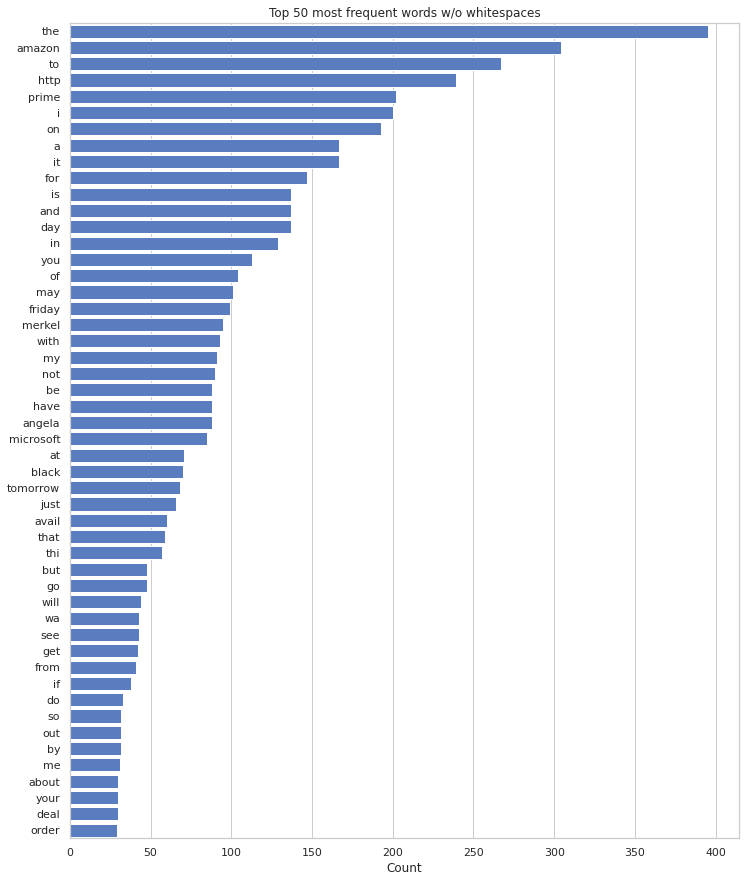

In [14]:
# top_words_dict = dict(top_words)
# for k in top_words_dict.keys():
#     if k.isspace():
#         top_words_dict.pop(k)

for w in list(words):
    if re.search("\W", w) is not None:
        print(w)
        del words[w]

top_words = words.most_common(50)
print(top_words)
show_histogram(top_words, title="Top 50 most frequent words w/o whitespaces")

Wyraźnie widać, że nawet bez znaków intepunkcyjnych pozostało dużo zbędnych tokenów. Poniżej lista słów, które często są oznaczane jako tzw. stopwords, czyli słowa występujące często a nie niosące informacji.

In [15]:
stopwords = ["a", "about", "after", "all", "am", "an", "and", "any", "are", "as", "at", "be", "because", "been",
             "before", "being", "between", "both", "by", "could", "did", "do", "does", "doing", "during", "each",
             "for", "from", "further", "had", "has", "have", "having", "he", "her", "here", "hers", "herself", "him",
             "himself", "his", "how", "i", "in", "into", "is", "it", "its", "itself", "let", "me", "more", "most", "my",
             "myself", "of", "on", "once", "only", "or", "other", "ought", "our", "ours", "ourselves", "own", "sha",
             "she", "should", "so", "some", "such", "than", "that", "the", "their", "theirs", "them", "themselves",
             "then", "there", "there's", "these", "they", "this", "those", "through", "to", "until", "up", "very",
             "was", "we", "were", "what", "when", "where", "which", "while", "who", "whom", "with", "would", "you",
             "your", "yours", "yourself", "yourselves",
             "n't", "'s", "'ll", "'re", "'d", "'m", "'ve",
             "above", "again", "against", "below", "but", "cannot", "down", "few", "if", "no", "nor", "not", "off",
             "out", "over", "same", "too", "under", "why"]

**Zad. 7: Korzystając z listy `sotpwords` usuń z kolekcji `words` popularne stopwords i ponów analizę. Czy wszystkie stopwords zawsze należy wyrzucać Czy słowa takie jak "not" mogą być nośnikiem opinii Jeśli masz jeszcze dużo czasu, możesz przeanalizować listę słów w nltk.corpus.stopwords.words('english')**

[('amazon', 304), ('http', 239), ('prime', 202), ('day', 137), ('may', 101), ('friday', 99), ('merkel', 95), ('angela', 88), ('microsoft', 85), ('black', 70), ('tomorrow', 68), ('just', 66), ('avail', 60), ('thi', 57), ('go', 48), ('will', 44), ('wa', 43), ('see', 43), ('get', 42), ('deal', 30), ('order', 29), ('ha', 28), ('sale', 28), ('time', 27), ('1st', 25), ('one', 25), ('new', 25), ('night', 24), ('now', 23), ('free', 23), ('can', 22), ('2nd', 21), ('got', 21), ('today', 21), ('look', 21), ('3rd', 20), ('like', 20), ('whi', 19), ('come', 19), ('say', 18), ('wednesday', 18), ('want', 18), ('thursday', 18), ('concert', 18), ('make', 17), ('us', 16), ('back', 16), ('monday', 16), ('tuesday', 16), ('germani', 16)]


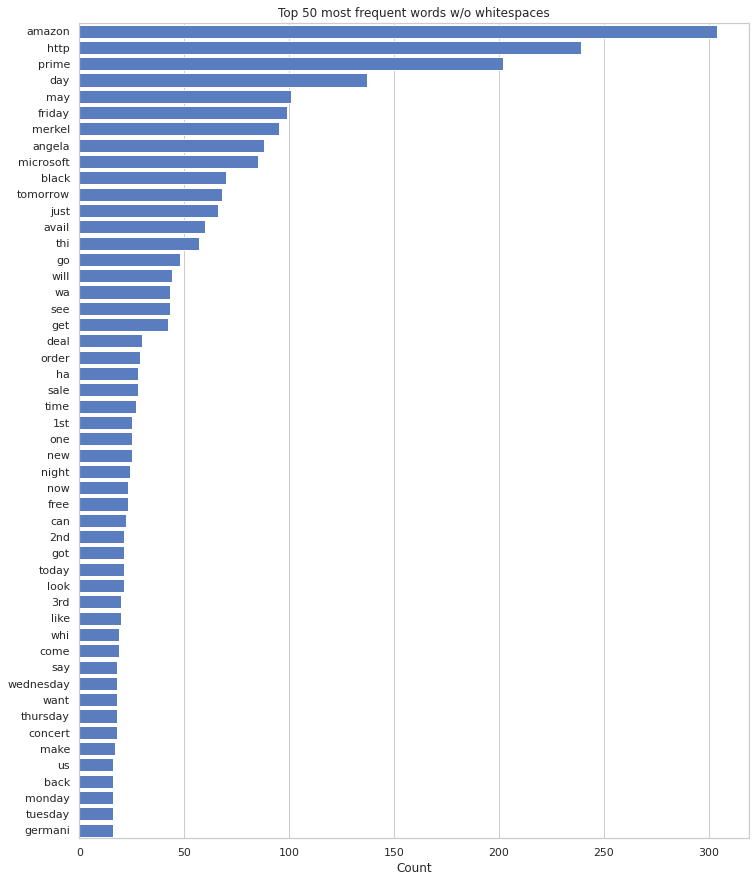

In [16]:
for w in stopwords:
    if w in words:
        del words[w]

top_words = words.most_common(50)
print(top_words)
show_histogram(top_words, title="Top 50 most frequent words w/o whitespaces")


Oprócz tokenów, które występują zbyt często, problemem bywają również najrzadsze tokeny.

**Zad. 8: Przeanalizuj 100 listę najrzadszych tokenów. Czy wszystkie tokeny są rzeczywiście rzadkie Czy jakieś typy tokenów powtarzają się Jak myślisz, co najlepiej zrobić z takimi tokenami jak 1, 2, 3... 10%, 20%, 30%..., 12:00, 19:50, 22:30, ..., 2005, 2010, 1995..., 10\$, 20\$, 30\$... **

[('weight', 1), ('defin', 1), ('french', 1), ('solut', 1), ('penis', 1), ('cultur', 1), ('belong', 1), ('9am', 1), ('bbc3cr', 1), ('debat', 1), ('illog', 1), ('democraci', 1), ('deutschen', 1), ('nazi', 1), ('accuss', 1), ('betray', 1), ('polic', 1), ('clear', 1), ('strong', 1), ('washington', 1), ('aug', 1), ('26', 1), ('barack', 1), ('voic', 1), ('conduct', 1), ('dnr', 1), ('lnr', 1), ('minsk', 1), ('agreement', 1), ('paulaedwy', 1), ('tat', 1), ('azerbaijan', 1), ('youngish', 1), ('abe', 1), ('fellow', 1), ('stanc', 1), ('canadian', 1), ('zone', 1), ('reform', 1), ('foxreg', 1), ('thearkoftwitt', 1), ('digniti', 1), ('stood', 1), ('ajweald', 1), ('passport', 1), ('admitt', 1), ('principl', 1), ('movement', 1), ('googlealert', 1), ('btw', 1), ('biographi', 1), ('predecessor', 1), ('gerhard', 1), ('schroeder', 1), ('22', 1), ('bild', 1), ('prayer', 1), ('hungari', 1), ('budapest', 1), ('catalonia', 1), ('reappli', 1), ('seced', 1), ('spain', 1), ('snp', 1), ('kthopkin', 1), ('favour',

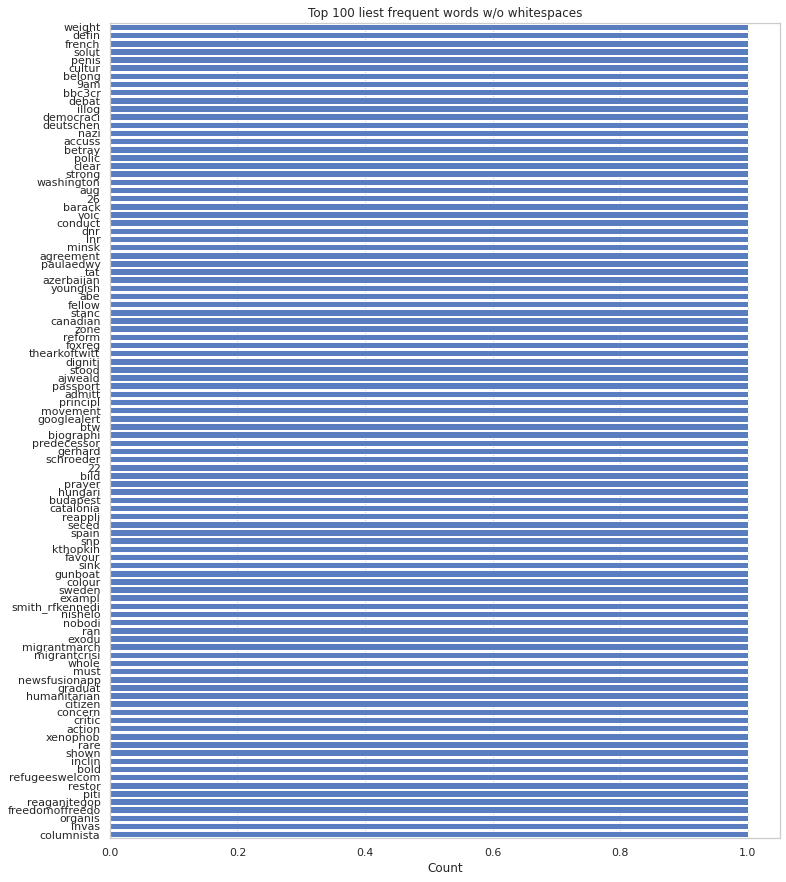

In [17]:
rarest_words = words.most_common()[-100:]
print(rarest_words)
show_histogram(rarest_words, title="Top 100 liest frequent words w/o whitespaces")

Na tym etapie w zmiennej `words` mamy wstępnie przygotowany słownik. Jak widać słownik możnaby jeszcze ulepszyć, ale w tym ćwiczeniu poprzestaniemy na tym co do tej pory zrobiliśmy.

## Klasyfikacja

Mając słownik zamienimy przykłady uczące na reprezentację bag of words (BOW). W tej reprezentacji każdy przykład uczący (pojedynczy dokument tekstowy) przyjmuje formę wektora liczb. Każda pozycja w wektorze oznacza kolejne słowo ze słownika, a liczba na danej pozycji mówi czy (0-1) lub jak często (0-k) dane słowo występuje w tekście. Taka reprezentacja wektorowa ma tę zaletę, że można ją łatwo rozszerzać o dodatkowe atrybuty.

**Zad. 9: Przeanalizuj poniższy kod tworzący reprezentację bag-of-words. Co to jest `csr_matrix` Czy wykorzystanie tej klasy jest konieczne**

In [18]:
def create_bow(documents, features):
    row = []
    col = []
    data = []

    labels = []

    for i in documents.index:
        tweet = BeforeTokenizationNormalizer.normalize(documents.iloc[i, 2])
        label = documents.iloc[i, 1]
        tweet_tokens = TweetTokenizer.tokenize(tweet)

        labels.append(label)
        for token in set(tweet_tokens):
            if token not in features:
                continue
            row.append(i)
            col.append(features[token])
            data.append(1)
    return csr_matrix((data, (row, col)), shape=(len(documents), len(features))), labels

Na koniec wykorzystajmy dotychczasową wiedzę, żeby nauczyć i przetestować klasyfikator.

**Zad. 10: Sprawdź działanie klasyfikatora Random Forest na przetworzonych wcześniej danych. Jak na trafność klasyfikacji wpływa parametr min_word_count**

In [19]:
from scipy.sparse import csr_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, precision_score, recall_score

min_word_count = 5

train_tweets = pd.read_csv("tweets_train.tsv", sep="\t", header=None)
test_tweets = pd.read_csv("tweets_test.tsv", sep="\t", header=None)
common_words = list([k for k, v in words.most_common() if v > min_word_count])

feature_dict = {}
for word in common_words:
    feature_dict[word] = len(feature_dict)

print("Training classifier...")
X_train, y_train = create_bow(train_tweets, feature_dict)
list_of_labels = list(set(y_train))
classifier = RandomForestClassifier(n_estimators=300, n_jobs=-1, random_state=23)
classifier.fit(X_train, y_train)

print("Testing...")
test_tweets = pd.read_csv("tweets_test.tsv", sep="\t", header=None)
X_test, y_test = create_bow(test_tweets, feature_dict)
predicted = classifier.predict(X_test)

print("=================== Results ===================")
print("            Positive    Neutral     Negative   ")
print("F1       ", f1_score(y_test, predicted, average=None, pos_label=None, labels=list_of_labels))
print("Precision", precision_score(y_test, predicted, average=None, pos_label=None, labels=list_of_labels))
print("Recall   ", recall_score(y_test, predicted, average=None, pos_label=None, labels=list_of_labels))

Training classifier...
Testing...
=================== Results ===================
            Positive    Neutral     Negative   
F1        [0.74509804 0.15384615 0.17948718]
Precision [0.62983425 0.18181818 0.53846154]
Recall    [0.912      0.13333333 0.10769231]


In [20]:
for min_word_count in [2, 5, 15, 20, 50, 70, 100]:
    train_tweets = pd.read_csv("tweets_train.tsv", sep="\t", header=None)
    test_tweets = pd.read_csv("tweets_test.tsv", sep="\t", header=None)
    common_words = list([k for k, v in words.most_common() if v > min_word_count])

    feature_dict = {}
    for word in common_words:
        feature_dict[word] = len(feature_dict)

    print("Training classifier...")
    X_train, y_train = create_bow(train_tweets, feature_dict)
    list_of_labels = list(set(y_train))
    classifier = RandomForestClassifier(n_estimators=300, n_jobs=-1, random_state=23)
    classifier.fit(X_train, y_train)

    print("Testing...")
    test_tweets = pd.read_csv("tweets_test.tsv", sep="\t", header=None)
    X_test, y_test = create_bow(test_tweets, feature_dict)
    predicted = classifier.predict(X_test)

    print("=================== Results ===================", f"|min_word_count={min_word_count}|")
    print("            Positive    Neutral     Negative   ")
    print("F1       ", f1_score(y_test, predicted, average=None, pos_label=None, labels=list_of_labels))
    print("Precision", precision_score(y_test, predicted, average=None, pos_label=None, labels=list_of_labels))
    print("Recall   ", recall_score(y_test, predicted, average=None, pos_label=None, labels=list_of_labels))

Training classifier...
Testing...
=================== Results =================== |min_word_count=2|
            Positive    Neutral     Negative   
F1        [0.74074074 0.1        0.        ]
Precision [0.60301508 0.2        0.        ]
Recall    [0.96       0.06666667 0.        ]
Training classifier...
Testing...
=================== Results =================== |min_word_count=5|
            Positive    Neutral     Negative   
F1        [0.74509804 0.15384615 0.17948718]
Precision [0.62983425 0.18181818 0.53846154]
Recall    [0.912      0.13333333 0.10769231]
Training classifier...
Testing...
=================== Results =================== |min_word_count=15|
            Positive    Neutral     Negative   
F1        [0.70707071 0.13333333 0.1686747 ]
Precision [0.61046512 0.13333333 0.38888889]
Recall    [0.84       0.13333333 0.10769231]
Training classifier...
Testing...
=================== Results =================== |min_word_count=20|
            Positive    Neutral     Negative 

/home/zerkles/PP_SEM_II/EMD/NltkNotebook/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
